# SARIMA MODELING

Import dataset

In [2]:
#Importing the libraries to watch the 'fits' image and get the data array
import astropy
import plotly.graph_objects as go
from astropy.io import fits
#Importing a library that is useful to read the original file
import pandas as pd
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#Importing a visual library with some illustrative set up
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
from matplotlib import cm
import numpy as np
import math 
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (16, 8) 
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
plt.rcParams["axes.grid"] = False

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256))) 
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

In [4]:
dataset = pd.read_csv('/Users/Simone/Desktop/University/DDA/Lab/Relazione_2_TimesSeries/reconstruction.csv')

dataset = dataset.drop(columns=['Unnamed: 0'])

full_load = pd.Series(dataset.R)


In [5]:
import csv
import datetime as dat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dir='/Users/Simone/Desktop/University/DDA/Lab/Relazione_2_TimesSeries/'
file='daneOkresoweKSE.csv'

# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv(dir+file) 
# Preview the first 5 lines of the loaded data 
data.head()


data = pd.read_csv(dir+file,skiprows=0,sep=';') 
data.head()


data.columns= ['Day','hour','minute','Load']
#plt.figure(figsize=(10, 10))    
#plt.plot(F606,F814,',k')
#plt.ylim(32,12)
#plt.xlim(32,12)
#plt.show()
#plt.close

Using 10000 entries on 315648 available


/Users/Simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



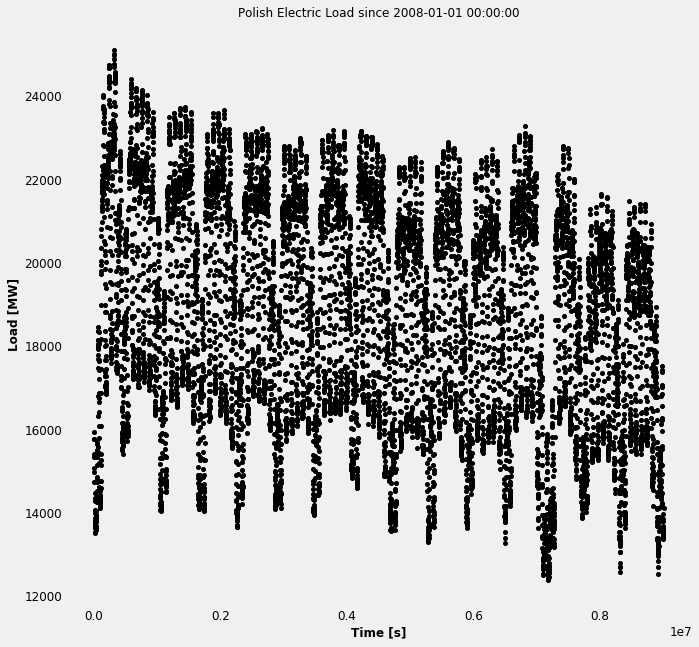

In [6]:
N= 10000# data.shape[0]
print("Using {} entries on {} available".format(N, data.shape[0]) )
load=np.zeros(N) #vogliamo mettere i vettori tempo in formato np, per fare successive analisi, in formato datetime può essere scomodo
time=np.zeros(N)


txt0 = "{} {:02d}:{:02d}:00".format(data['Day'][0],data['hour'][0],0)
T0= dat.datetime.strptime(txt0,'%Y-%m-%d %H:%M:%S')

dday=0
for i in range(N):
    load[i]=data['Load'][i]
    
    if data['hour'][i]==24: 
        data['hour'][i]=0
        dday=1
    
    txt = "{} {:02d}:{:02d}:00".format(data['Day'][i],data['hour'][i],data['minute'][i])
    date= dat.datetime.strptime(txt,'%Y-%m-%d %H:%M:%S')
    #Serve questo loop perché i polacchi segnano la mezzanotte in maniera differente
    if dday==1:
        date=date+dat.timedelta(days=1)
    Secs=(date-T0).total_seconds()
    time[i]=Secs
    dday=0

plt.figure(figsize=(10,10))
plt.plot(time,load,'.k')

plt.xlabel('Time [s]')
plt.ylabel('Load [MW]')
plt.title('Polish Electric Load since {} {:02d}:{:02d}:00'.format(data['Day'][0],data['hour'][0],0) )
plt.show()
#

In [8]:
s = data.Day.loc[0]
data.iloc[96]

Day       2008-01-02
hour               0
minute            15
Load           14343
Name: 96, dtype: object

In [9]:
data.tail()

,Day,hour,minute,Load
315643,2016-12-31,23,0,15952.7
315644,2016-12-31,23,15,15865.3
315645,2016-12-31,23,30,15693.5
315646,2016-12-31,23,45,15508.3
315647,2016-12-31,24,0,15235.2


In [10]:
from scipy import signal
dir='/Users/Simone/Desktop/University/DDA/Lab/Relazione_2_TimesSeries/'
file='daneOkresoweKSE.csv'

# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv(dir+file, sep =';') 
data=data.rename(columns={'Data':'Day','Godzina':'hour','Minuty':'minute','Wolumen':'Load'})
SECONDS=np.arange(900,900*len(data)+900,900)
data['seconds']=SECONDS
LOAD=data.Load
load_no_line=signal.detrend(LOAD,type='linear')
clean_load=np.array(load_no_line)-np.array(load_no_line).mean()
data['clean_load']=clean_load
data=data.drop(columns=['Load']).rename(columns={'clean_load':'Load'})

In [11]:
s = '2008-01-01 00:15:00'
end = '2017-01-01 00:00:00'

In [12]:
index = pd.date_range(start = s  , end = end , freq='15T')
series = pd.Series(data.Load.tolist(), index=index)
series.resample('1W').mean()

2008-01-06    2076.281897
2008-01-13    2610.956303
2008-01-20    2304.498029
2008-01-27    2084.919963
2008-02-03    2034.422105
2008-02-10    1768.430051
2008-02-17    2102.494693
2008-02-24    1801.520943
2008-03-02    1213.063710
2008-03-09    1437.014960
2008-03-16    1187.427667
2008-03-23    1122.991714
2008-03-30     374.910970
2008-04-06     505.298529
2008-04-13     458.393379
2008-04-20     380.559361
2008-04-27     -34.305312
2008-05-04   -1930.233676
2008-05-11    -685.940760
2008-05-18    -707.687874
2008-05-25   -1577.150463
2008-06-01    -843.120345
2008-06-08    -751.903917
2008-06-15    -866.625138
2008-06-22    -902.960198
2008-06-29    -907.140347
2008-07-06   -1096.254574
2008-07-13   -1175.293950
2008-07-20   -1365.830944
2008-07-27   -1184.420766
                 ...     
2016-06-12   -1010.707104
2016-06-19    -771.335914
2016-06-26    -284.608474
2016-07-03    -424.557820
2016-07-10   -1212.937076
2016-07-17    -921.523029
2016-07-24   -1010.078923
2016-07-31  

In [13]:
W=pd.DataFrame({'Time':series.resample('1W').mean().index,'Load':series.resample('1W').mean()})
M=pd.DataFrame({'Time':series.resample('1M').mean().index,'Load':series.resample('1M').mean()})
D=pd.DataFrame({'Time':series.resample('1D').mean().index,'Load':series.resample('1D').mean()})

In [14]:
M = M.drop(M.index[-1])

/Users/Simone/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0.5, 1.0, 'Monthly avarage of Polish Electric Load from 2008 to 2017')

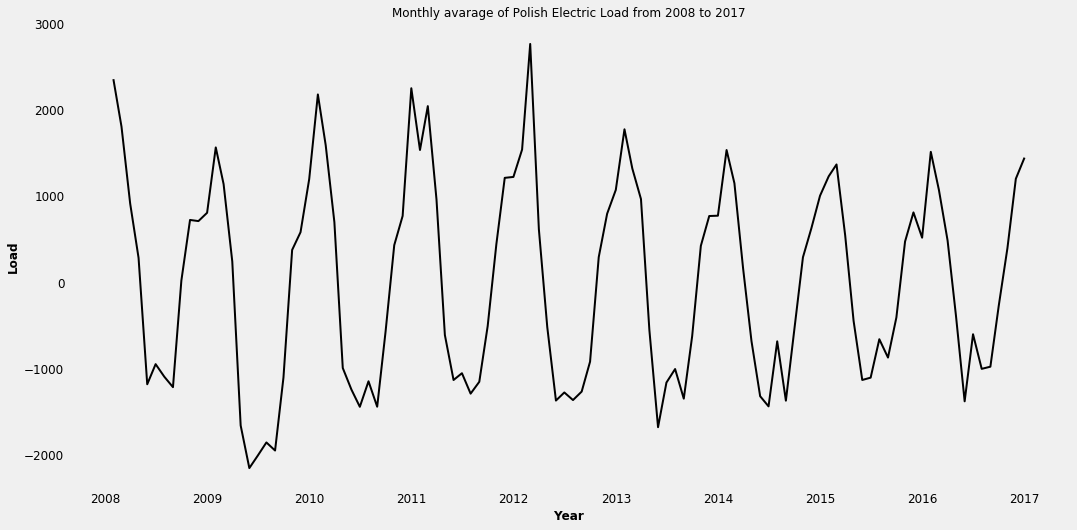

In [15]:
plt.plot(M.Load,color = 'k')
plt.xlabel('Year')
plt.ylabel('Load')
plt.title('Monthly avarage of Polish Electric Load from 2008 to 2017')


# Stationarity

Let's check stationary properties, let's plot the series, the series differencied 1 and 2 times, and test stationarity with ADF test

In [56]:
M['L_diff'] = M.Load.diff()

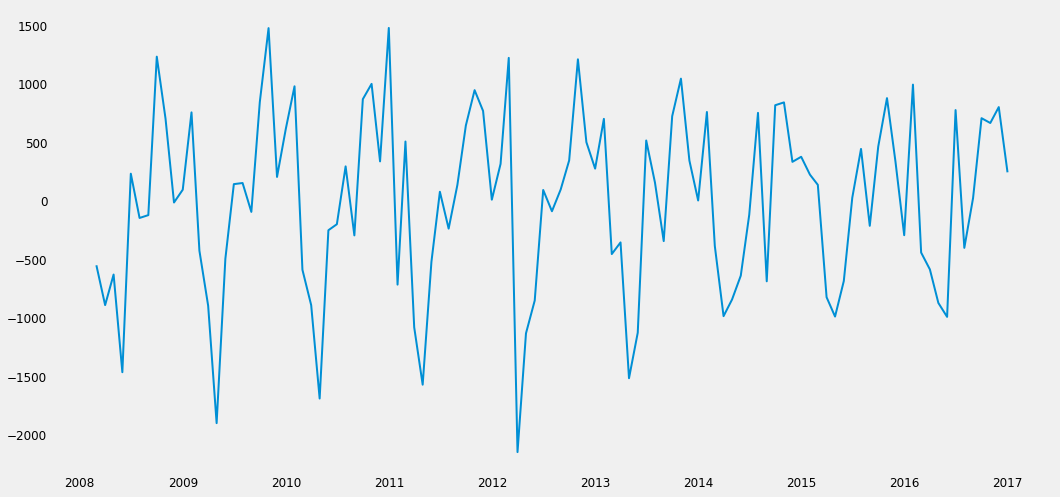

In [18]:
plt.plot(M.L_diff)

In [19]:
M['L_diff_2'] = M.L_diff.diff()

Text(0.5, 1.0, 'Monthly avarage of Polish Electric Load from 2008 to 2017')

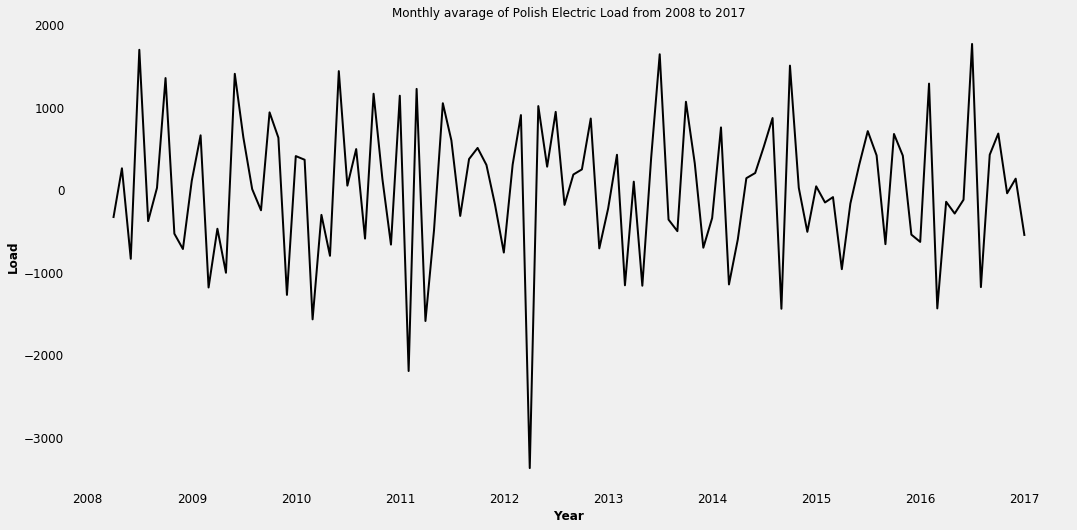

In [20]:
plt.plot(M.L_diff_2,color = 'k')
plt.xlabel('Year')
plt.ylabel('Load')
plt.title('Monthly avarage of Polish Electric Load from 2008 to 2017')



In [64]:
M = M.fillna(0)

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



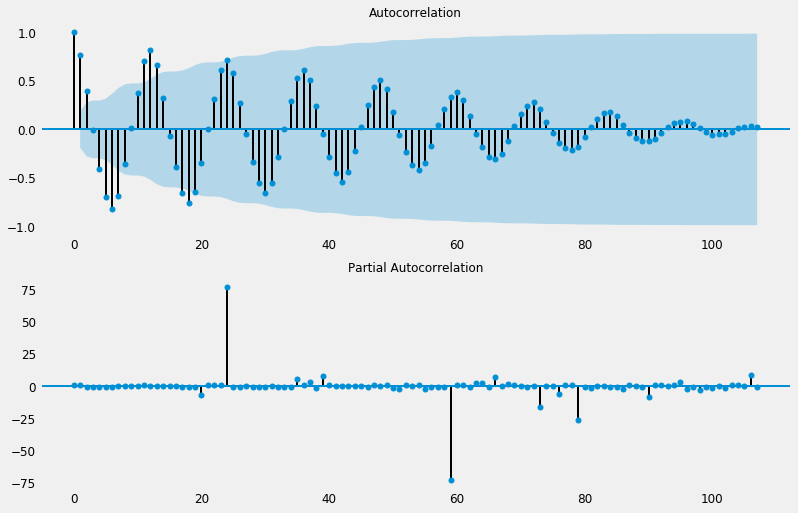

In [65]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(M.Load, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(M.Load, ax=ax2)

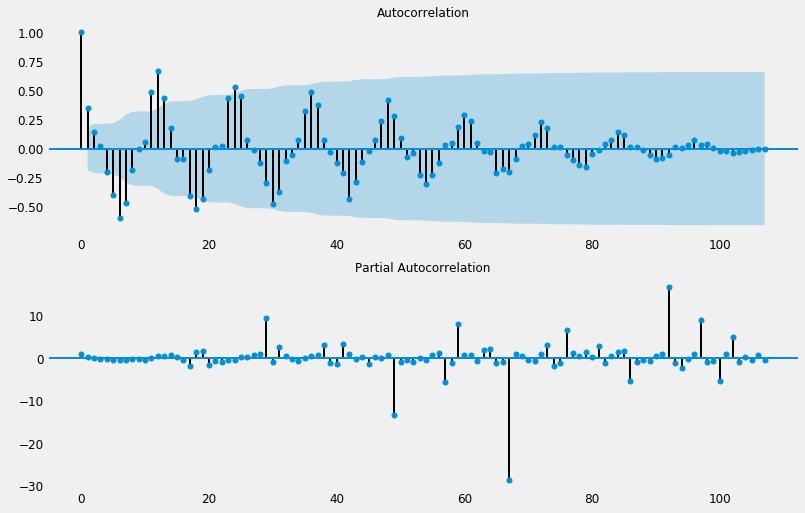

In [66]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(M.L_diff, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(M.L_diff, ax=ax2)

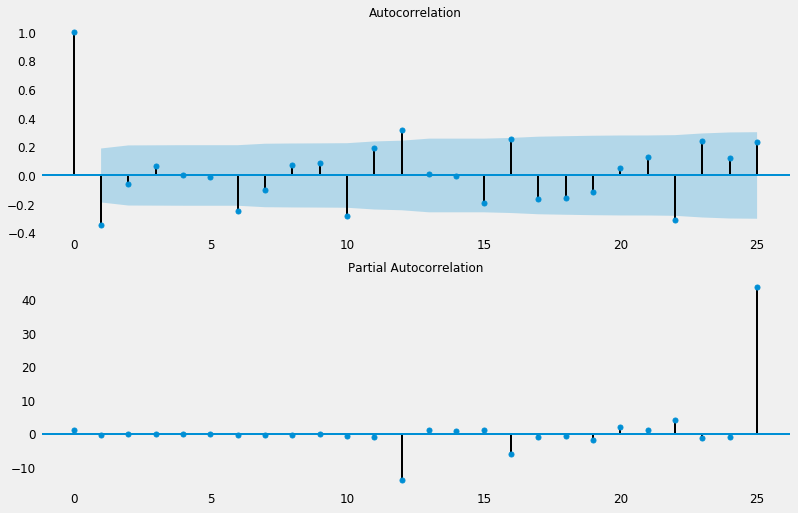

In [70]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(M.L_diff_2, ax=ax1, lags =25)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(M.L_diff_2, ax=ax2, lags = 25)

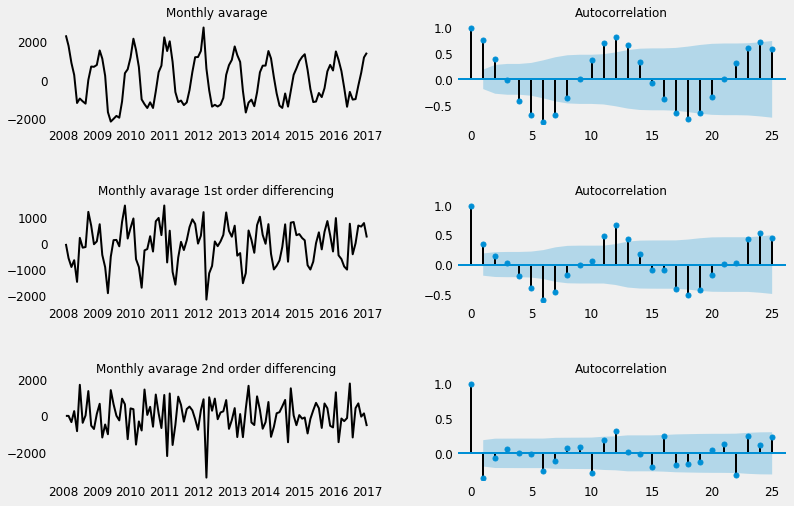

In [75]:
fig = plt.figure(figsize=(12,8))
ax11 = fig.add_subplot(321)
plt.plot(M.Load,color = 'k')

plt.title('Monthly avarage')

ax12 = fig.add_subplot(322)
fig = sm.graphics.tsa.plot_acf(M.Load, ax=ax12, lags =25)
ax21 = fig.add_subplot(323)
plt.plot(M.L_diff,color = 'k')

plt.title('Monthly avarage 1st order differencing')
ax22 = fig.add_subplot(324)
fig = sm.graphics.tsa.plot_acf(M.L_diff, ax=ax22, lags =25)
ax21 = fig.add_subplot(325)
plt.plot(M.L_diff_2,color = 'k')

plt.title('Monthly avarage 2nd order differencing')
ax22 = fig.add_subplot(326)
fig = sm.graphics.tsa.plot_acf(M.L_diff_2, ax=ax22, lags =25)
fig.tight_layout(pad=3.0)

In [69]:
result = adfuller(M.Load)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.6395663358906813
p-value: 0.08509228381508094
Critical Values:
	1%: -3.5019123847798657
	5%: -2.892815255482889
	10%: -2.583453861475781


In [76]:
result = adfuller(M.L_diff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.2652550456770366
p-value: 0.1834188188233724
Critical Values:
	1%: -3.5019123847798657
	5%: -2.892815255482889
	10%: -2.583453861475781


In [77]:
result = adfuller(M.L_diff_2)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -10.997897668817702
p-value: 6.797740387371707e-20
Critical Values:
	1%: -3.5011373281819504
	5%: -2.8924800524857854
	10%: -2.5832749307479226


# ARMA 

First of all we try to build An ARMA model on the data 

In [24]:
N = len(M.Load)
split = 0.85
training_size = round(split*N)
test_size = round((1-split)*N)

series = M.Load[:training_size]

In [25]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [26]:
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog = series)

result_df

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarni

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,"(p, d, q)",AIC
0,"(6, 0, 8)",1385.880441
1,"(9, 0, 9)",1387.425645
2,"(4, 0, 4)",1388.594984
3,"(5, 0, 8)",1389.162237
4,"(8, 0, 8)",1389.387779
5,"(5, 0, 9)",1389.763351
6,"(9, 0, 8)",1390.097295
7,"(7, 0, 8)",1391.313944
8,"(7, 0, 9)",1391.572833
9,"(2, 0, 3)",1392.307570


Try to fit the best model according to AIC

In [76]:
best_model = SARIMAX(series, order=(6,2,6)).fit()
print(best_model.summary())
s_best_model = SARIMAX(series, order=(6,0,8)).fit()
print(s_best_model.summary())



/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Statespace Model Results                           
Dep. Variable:                   Load   No. Observations:                   92
Model:               SARIMAX(6, 2, 6)   Log Likelihood                -678.301
Date:                Sat, 28 Nov 2020   AIC                           1382.601
Time:                        18:25:18   BIC                           1415.099
Sample:                    01-31-2008   HQIC                          1395.706
                         - 08-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5279      0.408      1.295      0.195      -0.271       1.327
ar.L2         -0.2791      0.644     -0.433      0.665      -1.542       0.984
ar.L3         -0.0252      0.763     -0.033      0.9

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



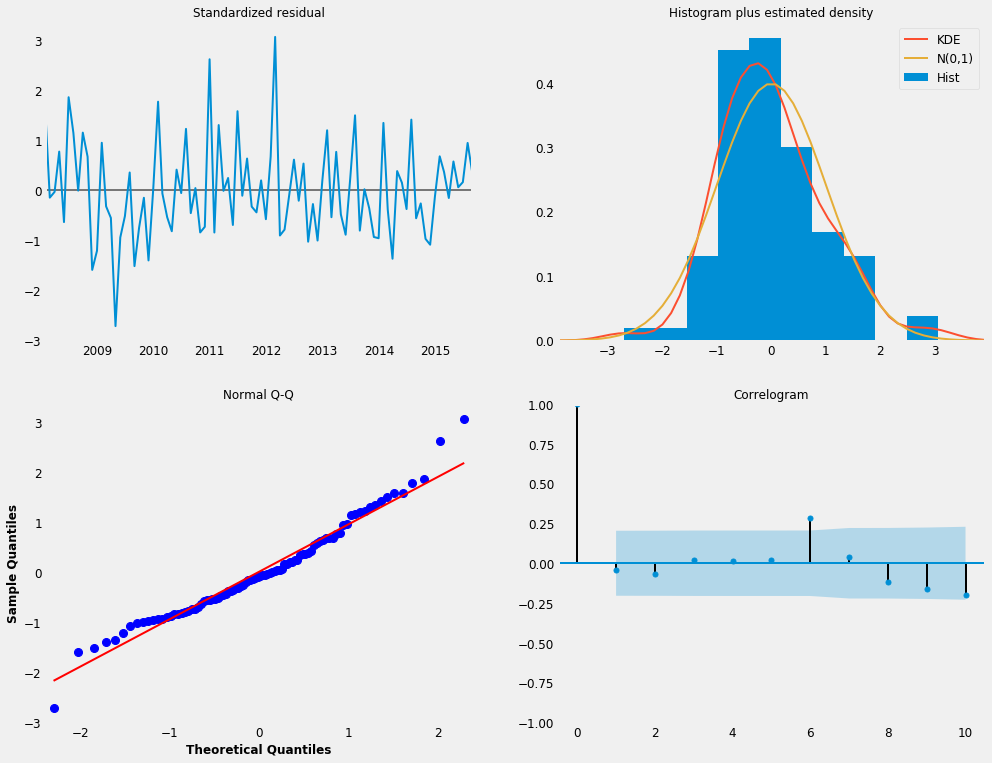

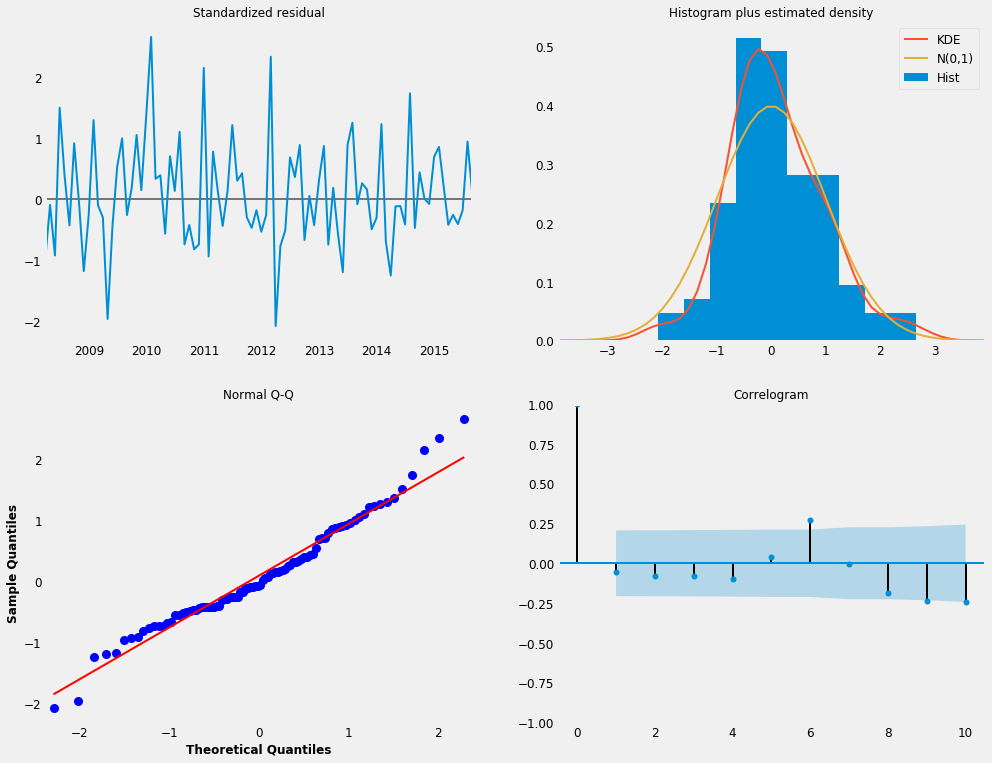

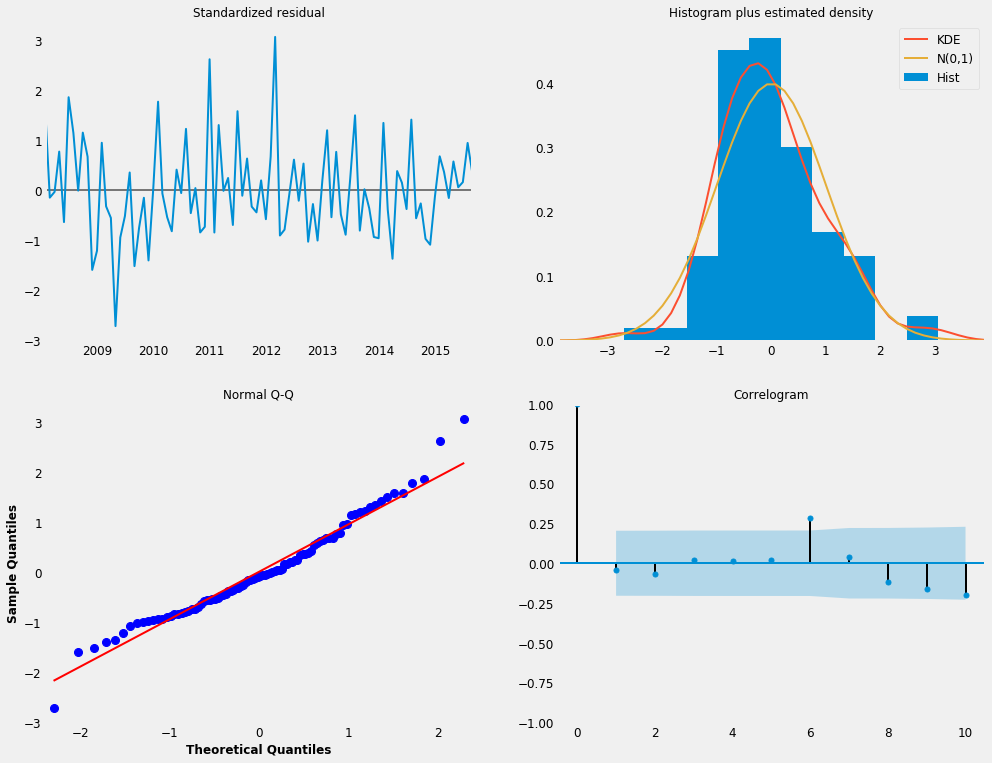

In [77]:
best_model.plot_diagnostics(figsize=(15,12))
s_best_model.plot_diagnostics(figsize=(15,12))

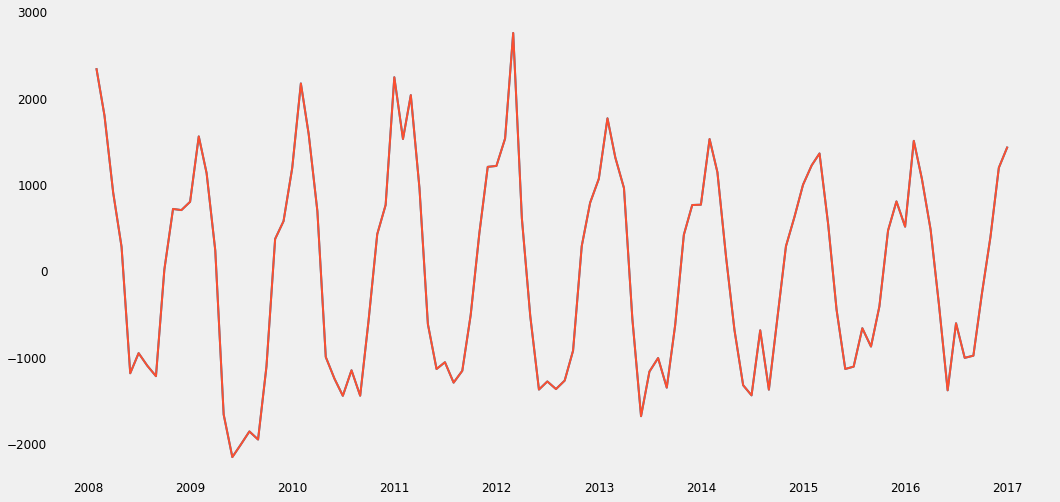

In [29]:
original_1 = M.L_diff_2.cumsum() + M.L_diff.max()-M.L_diff_2.cumsum().max()
original_1[0]=M.L_diff[0]
original_2 = original_1.cumsum() + M.Load.max()- original_1.cumsum().max()
original_2[0] = M.Load[0]
plt.plot(M.Load)
plt.plot(original_2)

Let's see how forecast performs

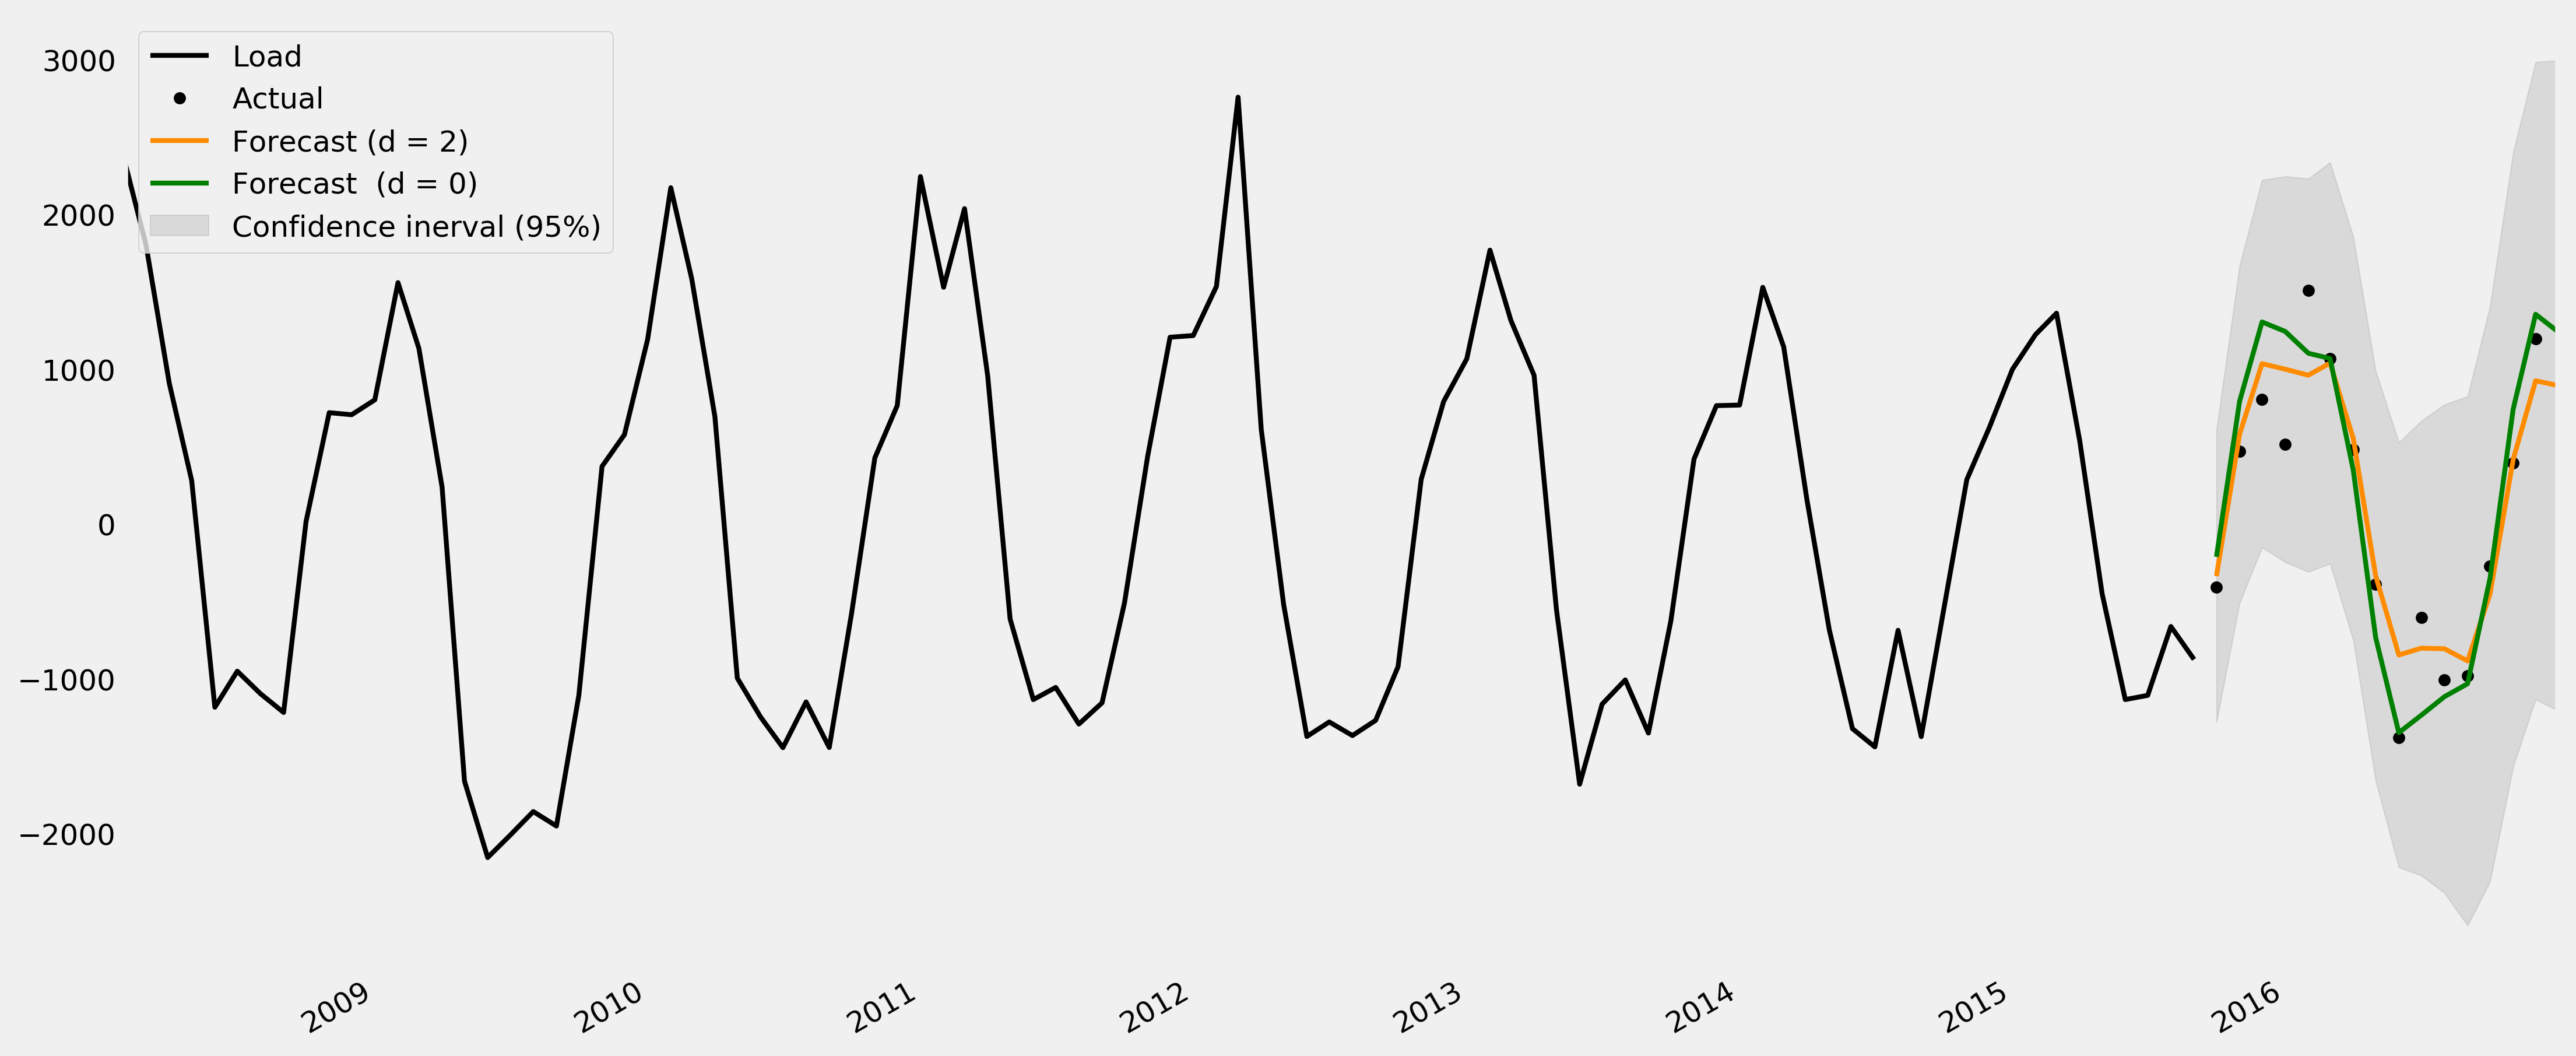

In [86]:

fore_l= test_size -1
forecast = best_model.get_prediction(start=training_size, end=training_size+fore_l)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

s_forecast = s_best_model.get_prediction(start=training_size, end=training_size+fore_l)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = M.Load.index[0:training_size]
x1=M.Load.index[training_size:training_size+fore_l+1]
#ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
plt.plot(x0, M.Load[0:training_size],'k', label = 'Load')

plt.plot(M.Load[training_size:training_size+fore_l], '.k', label = 'Actual')

forec = pd.DataFrame(forec, columns=['f'], index = x1)
forec.f.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
ax.fill_between(x1, ci['lower Load'], ci['upper Load'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

s_forec = pd.DataFrame(s_forec, columns=['f'], index = x1)
s_forec.f.plot(ax=ax,color = 'green',label = 'Forecast  (d = 0)')
#ax.fill_between(x1, s_ci['lower Load'], s_ci['upper Load'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.show()



In [89]:
from sklearn.metrics import mean_squared_error
RMSE_Arima = np.sqrt(mean_squared_error(M.Load[training_size:training_size+fore_l],forec.f[0:len(forec)-1]))
print('RMSE : {:.02f}'.format(RMSE_Arima))

RMSE : 270.22


In [90]:
RMSE_Arima/M.Load.max()

0.09791478567419479

In [91]:
from sklearn.metrics import mean_squared_error
RMSE_Arima = np.sqrt(mean_squared_error(M.Load[training_size:training_size+fore_l],s_forec.f[0:len(forec)-1]))
print('RMSE : {:.02f}'.format(RMSE_Arima))

RMSE : 345.64


In [92]:
RMSE_Arima/M.Load.max()

0.1252448294148559

# SARIMA

Let's see if taking care of seasonality could help building a better model, tre process is very similar to the one used for ARIMA modeling, however a decomposition tool helped us checking the stationarity components.

In [100]:
def get_stationarity(timeseries,window):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

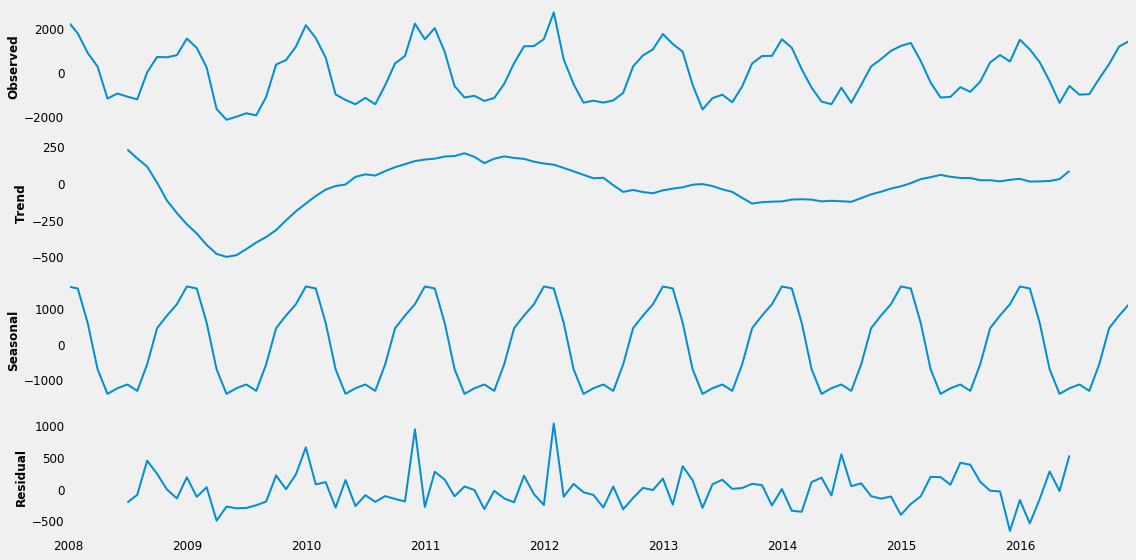

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(M.Load, model='additive')
result.plot()
plt.show()

In [101]:
len(S_series),len(RM_Load)

(92, 86)

In [102]:
N = len(M.Load)
split = 0.85
training_size = round(split*N)
test_size = round((1-split)*N)

S_series = M.Load[:training_size]

In [103]:
len(RM_Load)

86

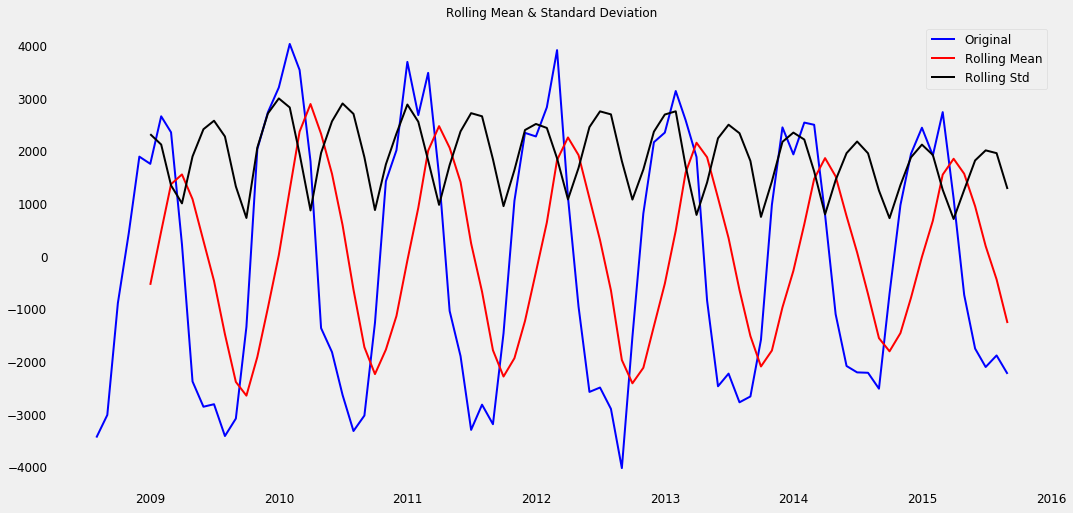

ADF Statistic: -3.9594882592556817
p-value: 0.0016381483646272187
Critical Values:
	1%: -3.5219803175527606
	5%: -2.9014701097664504
	10%: -2.58807215485756


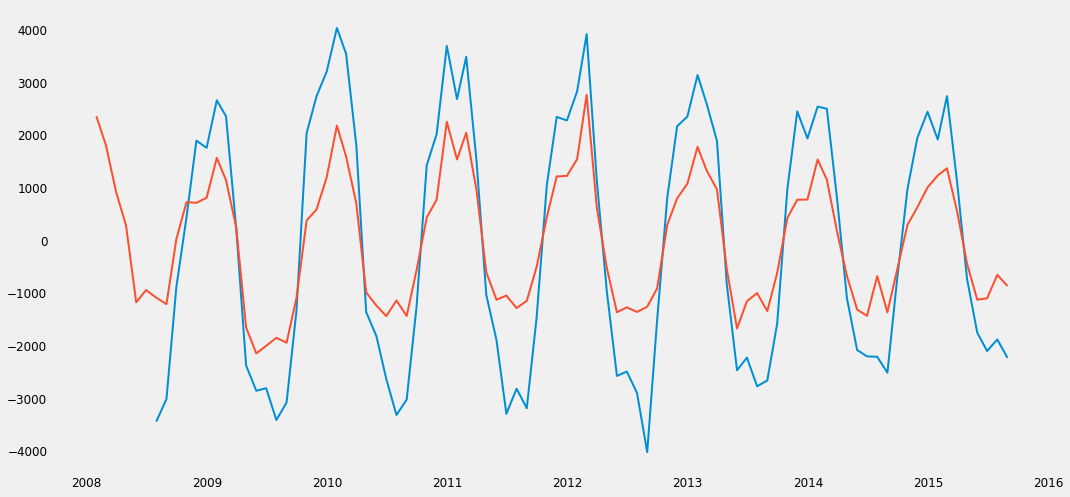

In [105]:
window = 6
rolling_mean = S_series.rolling(window=window).mean()
RM_Load = S_series.diff(window)
RM_Load.dropna(inplace=True)
get_stationarity(RM_Load,window)
plt.plot(RM_Load)
plt.plot(S_series)

In [106]:
validates = range(1,13,1)
p_0 = []
for v in validates:
    rolling_mean = S_series.rolling(window=v).mean()
    RM = S_series.diff(v)
    RM.dropna(inplace=True)
    result = adfuller(RM)
    p_0.append(result[1])


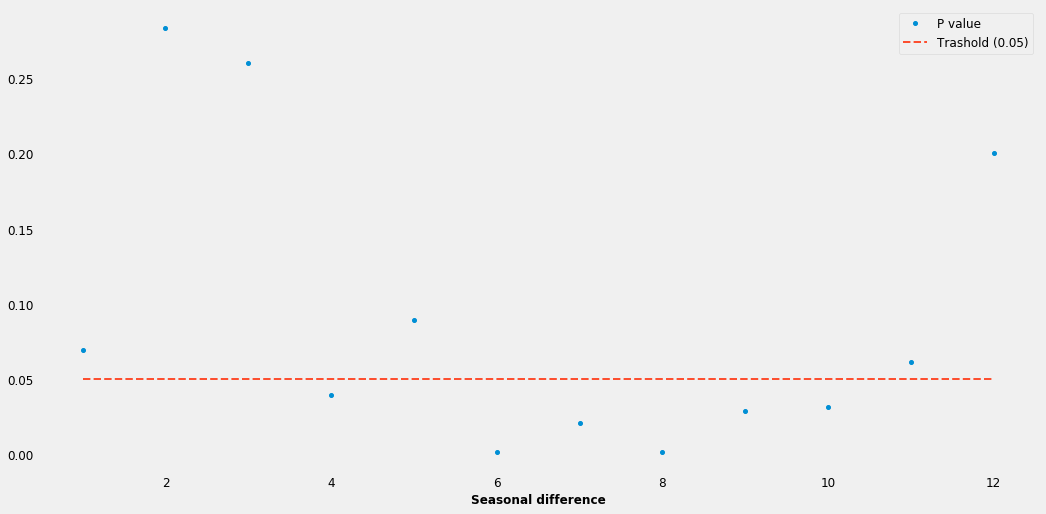

In [111]:
p_value = np.full(len(validates), fill_value= 0.05)
plt.plot(validates,p_0,'.',label = 'P value')
plt.plot(validates,p_value,'--',label= 'Trashold (0.05)')
plt.xlabel('Seasonal difference')
plt.legend()
#plt.ylim(0,0.01)

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



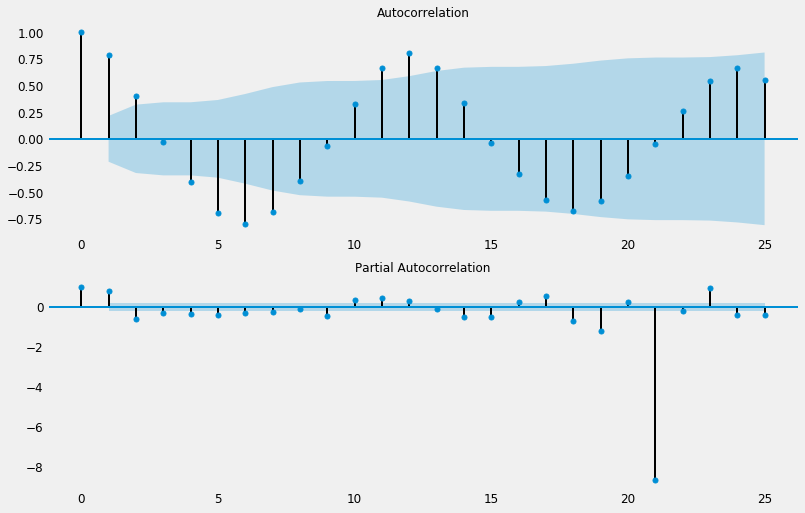

In [644]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(RM_Load, ax=ax1, lags =25)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(RM_Load, ax=ax2, lags = 25)

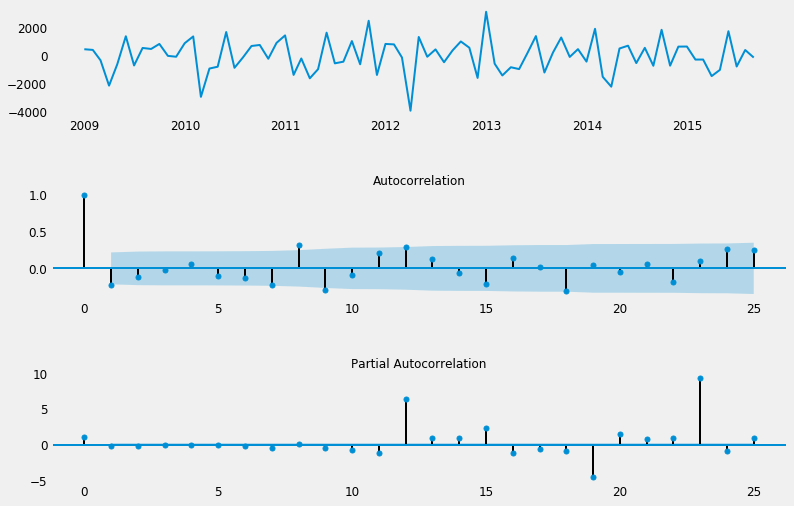

In [645]:
fig = plt.figure(figsize=(12,8))
ax3 = fig.add_subplot(311)
ax3.plot(RM_Load.diff().dropna().diff().dropna())
ax1 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_acf(RM_Load.diff().dropna().diff().dropna(), ax=ax1,lags =25)
ax2 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(RM_Load.diff().dropna().diff().dropna(), ax=ax2,lags=25)
fig.tight_layout(pad=3.0)


In [121]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0],d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [122]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 6
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [123]:
result_df = optimize_SARIMA(parameters_list, d, D, s , S_series)
result_df

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarni

,"(p,q)x(P,Q)",AIC
0,"(3, 0, 1, 2)",1285.195658
1,"(2, 0, 1, 2)",1289.951245
2,"(2, 1, 1, 2)",1290.437453
3,"(3, 1, 2, 2)",1293.928174
4,"(3, 1, 1, 2)",1293.954130
5,"(2, 0, 3, 1)",1295.994623
6,"(3, 0, 3, 0)",1297.836415
7,"(0, 2, 1, 2)",1298.008975
8,"(1, 0, 1, 2)",1299.667200
9,"(2, 0, 3, 0)",1301.023423


Again building two models for comparison

In [113]:
best_model = SARIMAX(S_series, order=(3, 2, 1), seasonal_order=(1, 1, 2, 6)).fit(disp=-1)
print(best_model.summary())
s_best_model = SARIMAX(S_series, order=(3,0, 1), seasonal_order=(1, 1, 2, 6)).fit(disp=-1)
print(s_best_model.summary())

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                 Statespace Model Results                                
Dep. Variable:                              Load   No. Observations:                   92
Model:             SARIMAX(3, 2, 1)x(1, 1, 2, 6)   Log Likelihood                -626.676
Date:                           Sun, 29 Nov 2020   AIC                           1269.353
Time:                                   12:28:16   BIC                           1288.799
Sample:                               01-31-2008   HQIC                          1277.170
                                    - 08-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7343      0.107     -6.871      0.000      -0.944      -0.525
ar.L2         -0.3098      0.162     -1.907

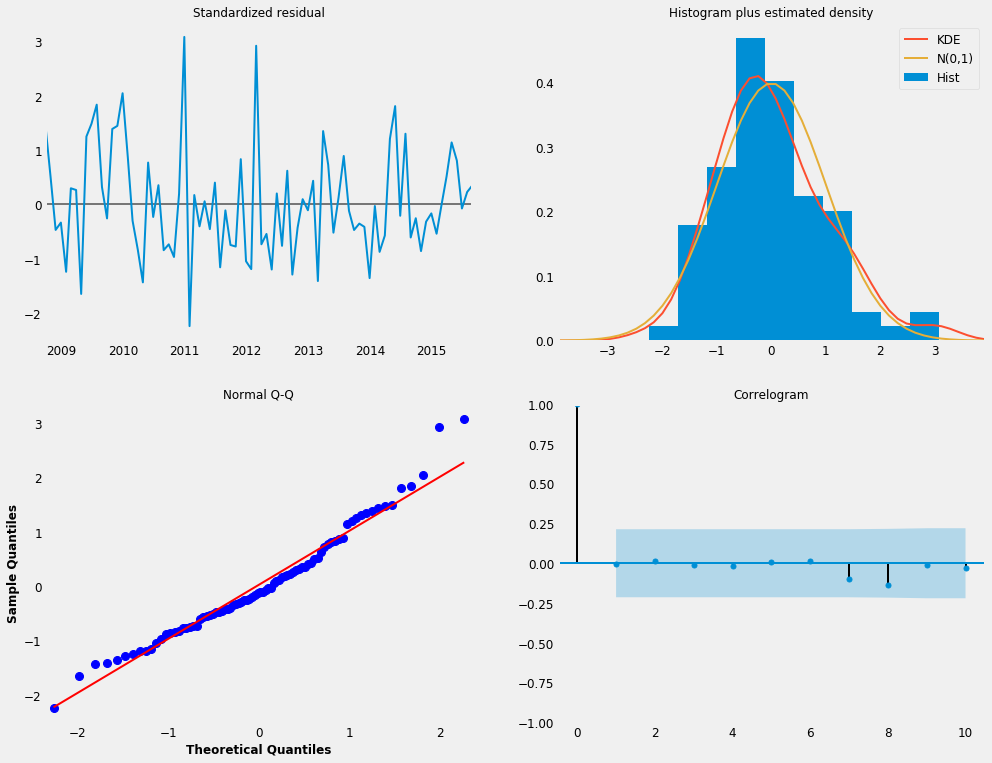

In [120]:
best_model.plot_diagnostics(figsize=(15,12));

/Users/Simone/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



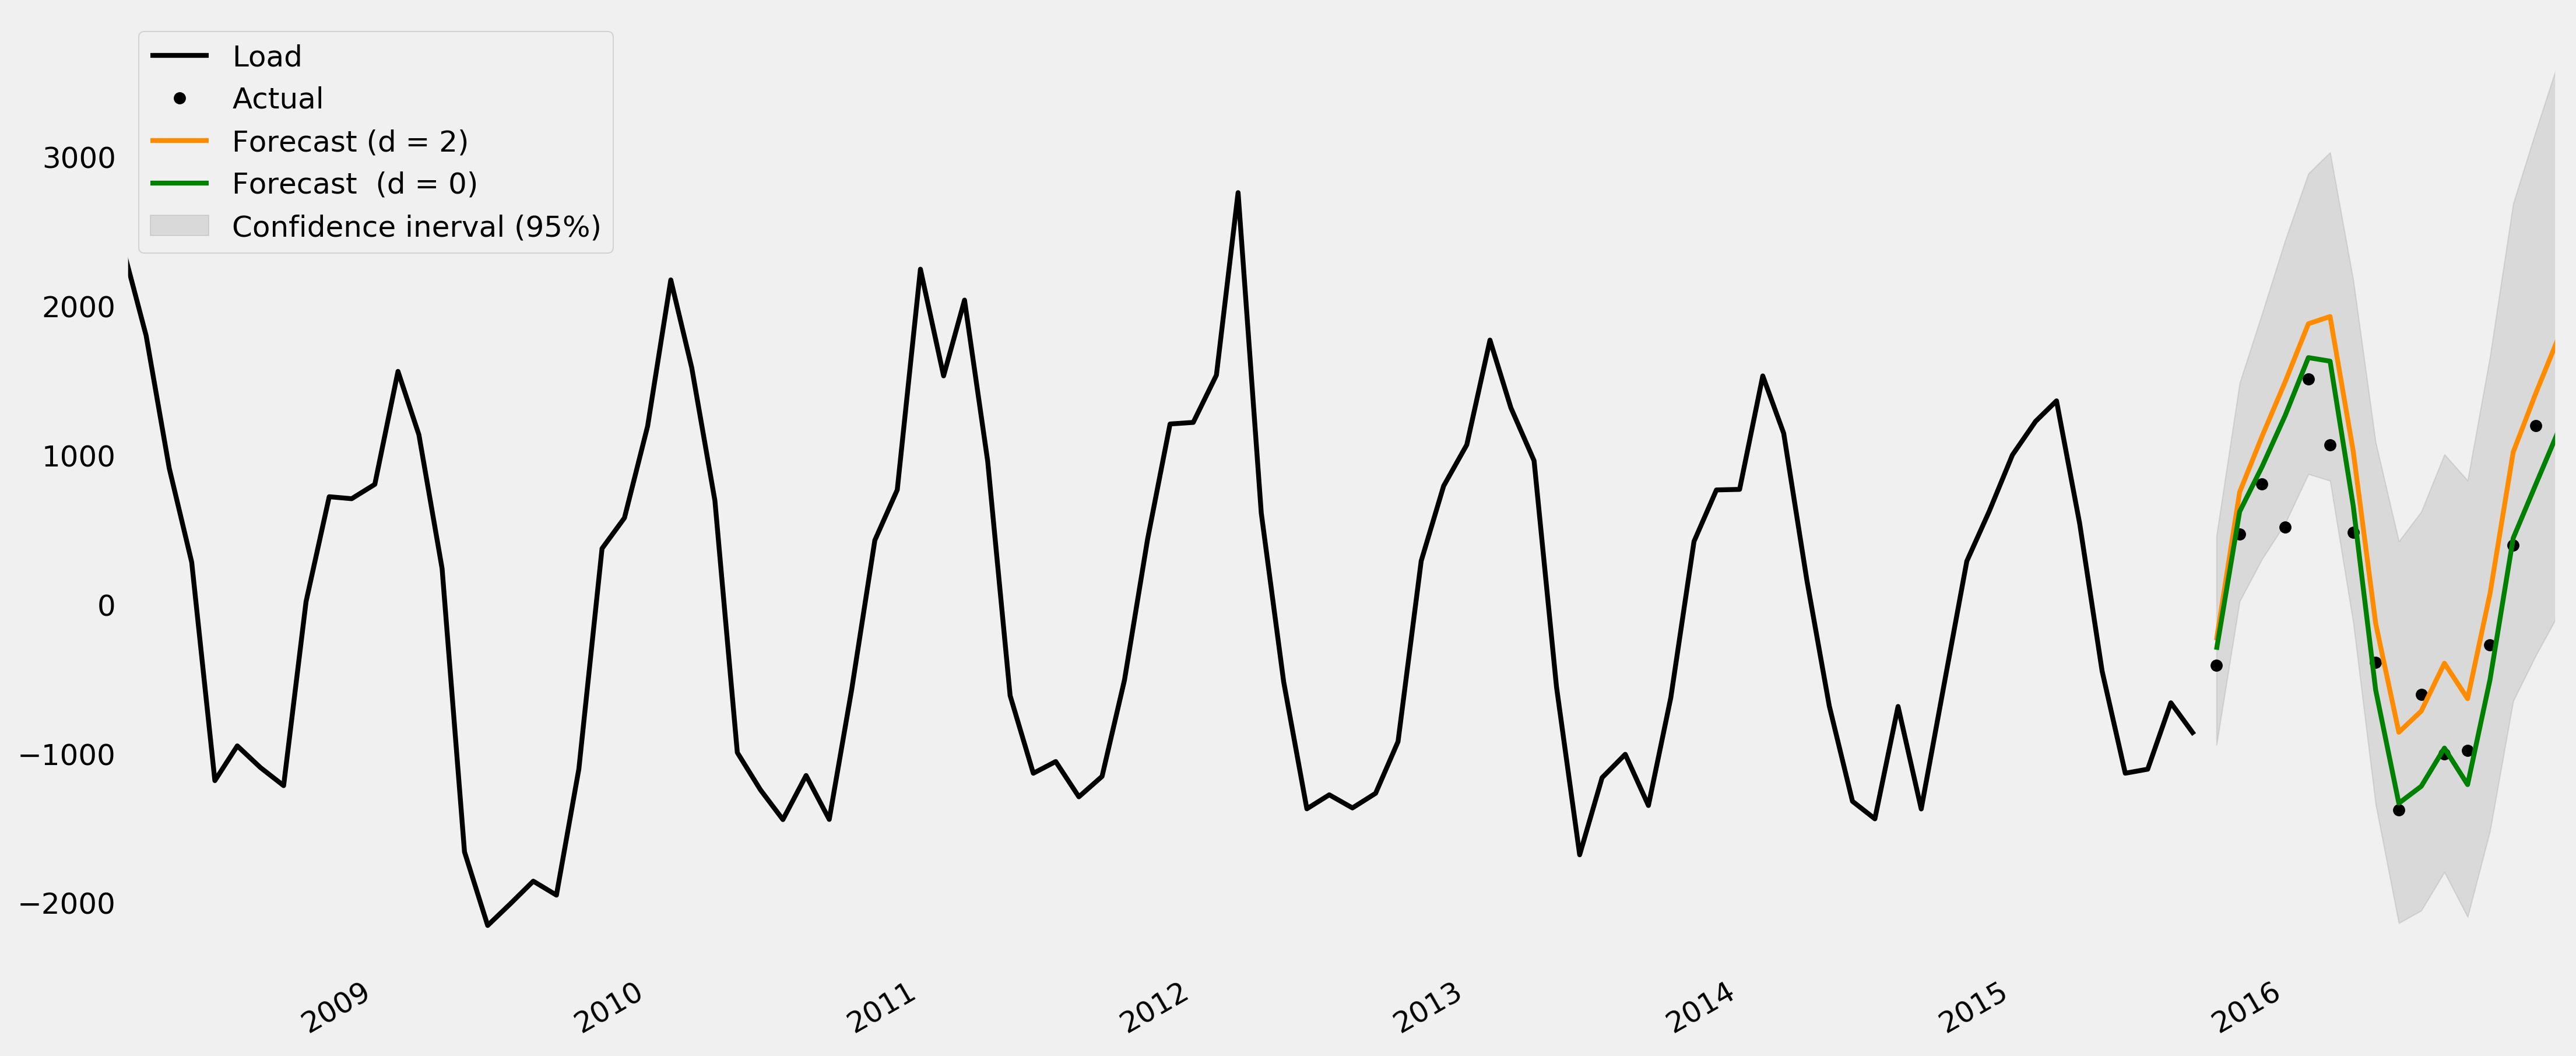

In [115]:

fore_l= test_size -1
forecast = best_model.get_prediction(start=training_size, end=training_size+fore_l)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

s_forecast = s_best_model.get_prediction(start=training_size, end=training_size+fore_l)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = M.Load.index[0:training_size]
x1=M.Load.index[training_size:training_size+fore_l+1]
#ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
plt.plot(x0, M.Load[0:training_size],'k', label = 'Load')

plt.plot(M.Load[training_size:training_size+fore_l], '.k', label = 'Actual')

forec = pd.DataFrame(forec, columns=['f'], index = x1)
forec.f.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
ax.fill_between(x1, ci['lower Load'], ci['upper Load'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

s_forec = pd.DataFrame(s_forec, columns=['f'], index = x1)
s_forec.f.plot(ax=ax,color = 'green',label = 'Forecast  (d = 0)')
#ax.fill_between(x1, s_ci['lower Load'], s_ci['upper Load'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.show()




In [116]:
RMSE_Sarima = np.sqrt(mean_squared_error(M.Load[training_size:training_size+fore_l],forec.f[0:len(forec)-1]))
print('RMSE : {:.02f}'.format(RMSE_Sarima))

RMSE : 498.38


In [117]:
RMSE_Sarima/M.Load.max()

0.18059037901112

In [124]:
RMSE_Sarima = np.sqrt(mean_squared_error(M.Load[training_size:training_size+fore_l],s_forec.f[0:len(forec)-1]))
print('RMSE : {:.02f}'.format(RMSE_Sarima))

RMSE : 332.94


In [125]:
RMSE_Sarima/M.Load.max()

0.12064102772131459